In [237]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline 

from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

In [2]:
my_host  = "localhost"
my_port = "5432"
my_name = "postgres"
my_pwd = "54zhusiqi"
my_db = "postgres"


In [3]:
schema = 'kaggle_hcdr'
#table_list = ['application_test', 'application_train', 'bureau', 'bureau_balance', 'credit_card_balance', 'home_credit_columns_description', 'installments_payments', 'pos_cash_balance', 'previous_application', 'sample_submission']
#[application_test, application_train, bureau, bureau_balance, credit_card_balance, home_credit_columns_description, installments_payments, pos_cash_balance, previous_application, sample_submission] = ['']*len(table_list)

table_list = ['application_train']
[application_train] = ['']*len(table_list)


# Data extraction from database

In [4]:
def get_data(my_host, my_port, my_db, my_name, my_pwd, schema, table_list):
    conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(my_host, my_port, my_db, my_name, my_pwd))

    data_all = []
    for t in table_list:
        print('Processing: {}'.format(t))
        sql = "select * from {}.{};".format(schema, t)
        data_all.append(sqlio.read_sql_query(sql, conn))
    conn = None
    return data_all

In [5]:
[application_train] = get_data(my_host, my_port, my_db, my_name, my_pwd, schema, table_list)

Processing: application_train


# Check the data

In [6]:
application_train.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,sk_id_bureau,months_balance,status
0,100002.0,1.0,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,None,None,None
1,100003.0,0.0,Cash loans,F,N,N,0.0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None
2,100004.0,0.0,Revolving loans,M,Y,Y,0.0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None
3,100006.0,0.0,Cash loans,F,N,Y,0.0,135000.0,312682.5,29686.5,...,0.0,None,None,None,None,None,None,None,None,None
4,100007.0,0.0,Cash loans,M,N,Y,0.0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None


In [7]:
application_train.shape

(307511, 125)

In [8]:
application_train.columns.values

array(['sk_id_curr', 'target', 'name_contract_type', 'code_gender',
       'flag_own_car', 'flag_own_realty', 'cnt_children',
       'amt_income_total', 'amt_credit', 'amt_annuity', 'amt_goods_price',
       'name_type_suite', 'name_income_type', 'name_education_type',
       'name_family_status', 'name_housing_type',
       'region_population_relative', 'days_birth', 'days_employed',
       'days_registration', 'days_id_publish', 'own_car_age',
       'flag_mobil', 'flag_emp_phone', 'flag_work_phone',
       'flag_cont_mobile', 'flag_phone', 'flag_email', 'occupation_type',
       'cnt_fam_members', 'region_rating_client',
       'region_rating_client_w_city', 'weekday_appr_process_start',
       'hour_appr_process_start', 'reg_region_not_live_region',
       'reg_region_not_work_region', 'live_region_not_work_region',
       'reg_city_not_live_city', 'reg_city_not_work_city',
       'live_city_not_work_city', 'organization_type', 'ext_source_1',
       'ext_source_2', 'ext_source_3',

# Check missing values

In [9]:
def check_missing_data(data, SORT = True):
    N_missing = data.isnull().sum()
    percent = N_missing / len(data) * 100
    if SORT == 'False':
        return pd.concat([N_missing, percent], axis=1, keys=['N_missing', 'Percent %'])
    else:
        return pd.concat([N_missing, percent], axis=1, keys=['N_missing', 'Percent %']).sort_values(by='N_missing', ascending=False)

In [10]:
application_train_missing = check_missing_data(application_train)

### Check top 10 missing data

In [11]:
application_train_missing[:10]

,N_missing,Percent %
status,307511,100.000000
months_balance,307511,100.000000
sk_id_bureau,307511,100.000000
commonarea_avg,214865,69.872297
commonarea_medi,214865,69.872297
commonarea_mode,214865,69.872297
nonlivingapartments_avg,213514,69.432963
nonlivingapartments_medi,213514,69.432963
nonlivingapartments_mode,213514,69.432963
fondkapremont_mode,210295,68.386172


### 100% missing for 'status', 'months_balance' and 'sk_id_bureau', we may ignore them

In [12]:
application_train_missing[3:13]

,N_missing,Percent %
commonarea_avg,214865,69.872297
commonarea_medi,214865,69.872297
commonarea_mode,214865,69.872297
nonlivingapartments_avg,213514,69.432963
nonlivingapartments_medi,213514,69.432963
nonlivingapartments_mode,213514,69.432963
fondkapremont_mode,210295,68.386172
livingapartments_mode,210199,68.354953
livingapartments_medi,210199,68.354953
livingapartments_avg,210199,68.354953


# Data exploration

### Data balance

In [13]:
def draw_pie_chart(data):    
    labels = data.index
    sizes = data['Percent %']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False)
    fig = plt.gcf()
    fig.set_size_inches(8, 8)

In [14]:
def check_balance(data, feature):
    tmp_pd = data[feature]
    count = tmp_pd.value_counts()
    percent = count / len(tmp_pd) * 100
    result = pd.concat([count, percent], axis=1, keys=['count', 'Percent %'])
    return result

,count,Percent %
0.0,282686,91.927118
1.0,24825,8.072882


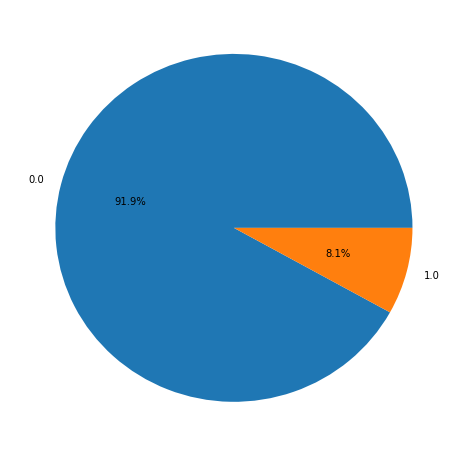

In [15]:
target_balance = check_balance(application_train, 'target')
draw_pie_chart(target_balance)
target_balance

# Compare the distribution for data with different targes

In [18]:
def compare_percent(data, feature):
    df_0 = check_balance(data[data['target'] == 0], feature)
    df_1 = check_balance(data[data['target'] == 1], feature)
    tmp_data = np.array([df_0['count'].tolist(), df_1['count'][df_0.index].tolist()])
   
    fig, ax = plt.subplots()
    size = 0.3
    cmap = plt.get_cmap("tab20c")
    outer_colors = cmap(np.arange(3)*4)
    inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))
    tmp_data = tmp_data.T
    ax.pie(tmp_data.sum(axis=1), radius=1 - size, colors=outer_colors,
           wedgeprops=dict(width=size, edgecolor='w'), labels=df_0.index, autopct='%1.1f%%', 
           pctdistance=0.5, labeldistance=0.6)

    ax.pie(tmp_data.flatten(), radius=1, colors=inner_colors,
           wedgeprops=dict(width=size, edgecolor='w'), labels=['0', '1'] * len(tmp_data), 
           autopct='%1.1f%%', explode = [int(i/2)*0.1 for i in range(len(tmp_data)*2)],
           pctdistance=0.8, labeldistance=1.1)

    ax.set(aspect="equal", title= 'Compare {} data for different labels'.format(feature))

    fig = plt.gcf()
    fig.set_size_inches(12, 12)
    
    return tmp_data

In [19]:
application_train.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,sk_id_bureau,months_balance,status
0,100002.0,1.0,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,None,None,None
1,100003.0,0.0,Cash loans,F,N,N,0.0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None
2,100004.0,0.0,Revolving loans,M,Y,Y,0.0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None
3,100006.0,0.0,Cash loans,F,N,Y,0.0,135000.0,312682.5,29686.5,...,0.0,None,None,None,None,None,None,None,None,None
4,100007.0,0.0,Cash loans,M,N,Y,0.0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None


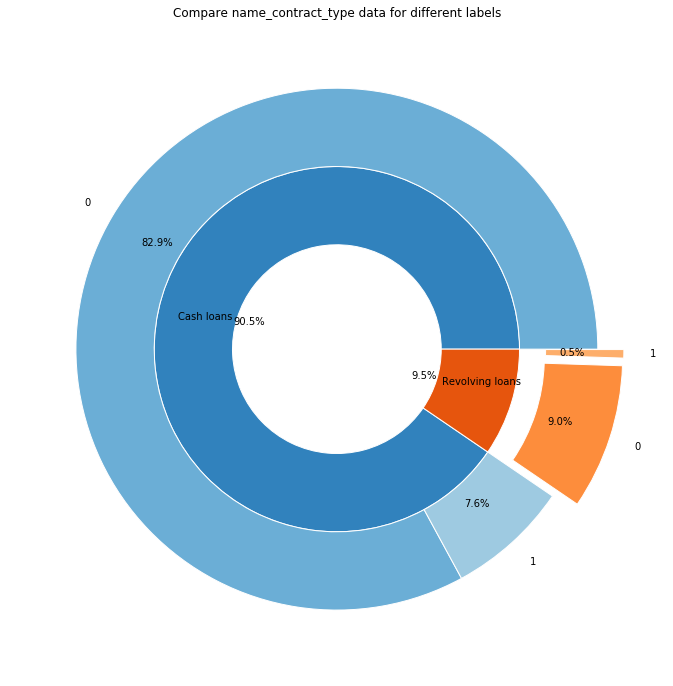

In [20]:
vals = compare_percent(application_train, 'name_contract_type')

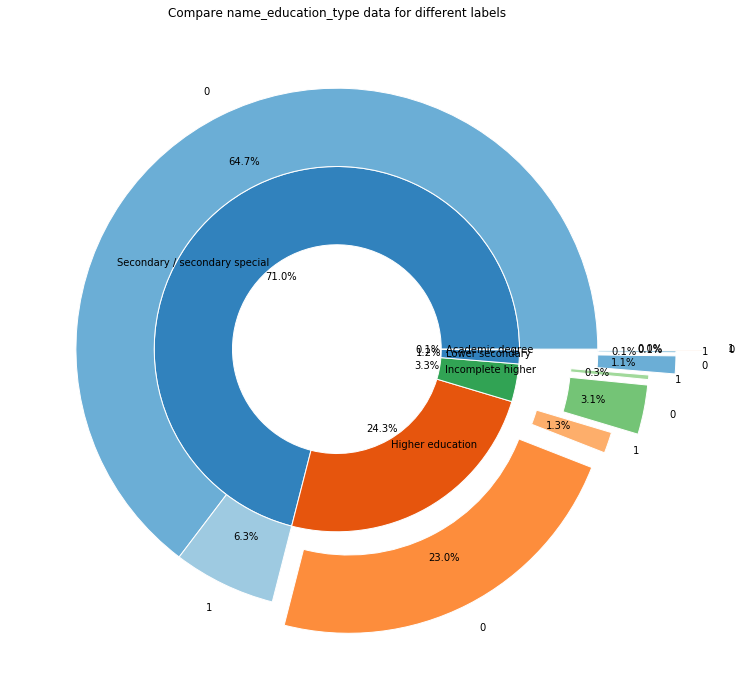

In [21]:
vals = compare_percent(application_train, 'name_education_type')

In [22]:
def compare_bar(data, feature):
    df_0 = check_balance(data[data['target'] == 0], feature)
    df_1 = check_balance(data[data['target'] == 1], feature)
    tmp_data = np.array([df_0['count'].tolist(), df_1['count'][df_0.index].tolist()])
   
    fig, ax = plt.subplots()
    
    N = len(tmp_data[0])
    ind = np.arange(N)
    
    b1 = plt.bar(ind, tmp_data[1] + tmp_data[0], color=(0.1, 0.6, 0.1, 0.6))
    b0 = plt.bar(ind, tmp_data[0], color=(0.1, 0.1, 0.6, 0.6))
    
    plt.ylabel('N_Observation')
    plt.xticks(ind, (df_0.index))
    plt.legend((b1[0], b0[0]), ('Target == 1', 'Target == 0'))

    ax.set(title= 'Compare {} data for different labels'.format(feature))

    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    
    plt.show()
    return tmp_data

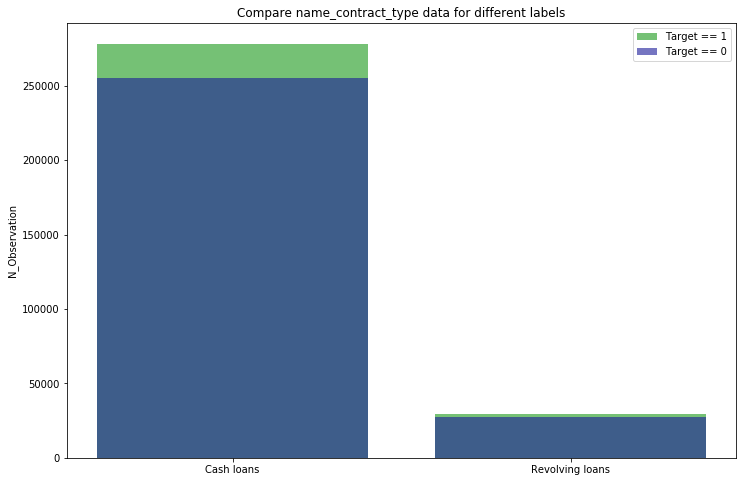

In [23]:
vals = compare_bar(application_train, 'name_contract_type')

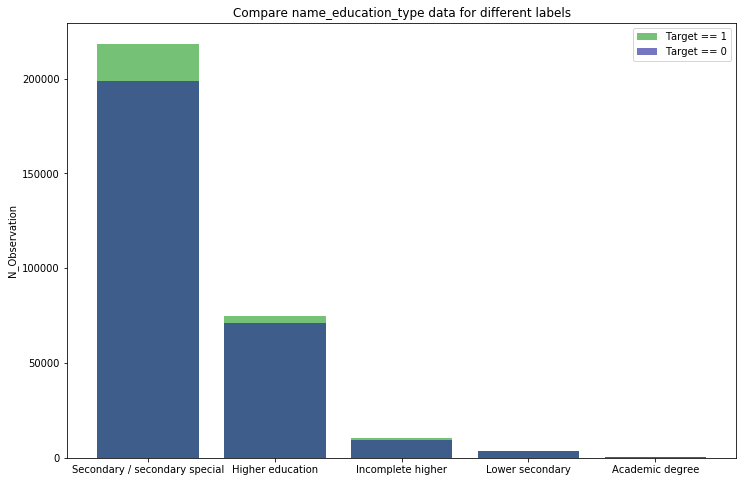

In [24]:
vals = compare_bar(application_train, 'name_education_type')

In [25]:
def compare_bar_percent(data, feature):
    df_0 = check_balance(data[data['target'] == 0], feature)
    df_1 = check_balance(data[data['target'] == 1], feature)
    tmp_data = np.array([df_0['count'].tolist(), df_1['count'][df_0.index].tolist()])
    tmp_data = np.array([d / np.sum(d) for d in tmp_data.T]).T
    fig, ax = plt.subplots()
    
    N = len(tmp_data[0])
    ind = np.arange(N)    # the x locations for the groups
    
    b1 = plt.bar(ind, tmp_data[1] + tmp_data[0], color=(0.1, 0.6, 0.1, 0.6))
    b0 = plt.bar(ind, tmp_data[0], color=(0.1, 0.1, 0.6, 0.6))
    
    plt.ylabel('N_Observation')
    plt.xticks(ind, (df_0.index))
    plt.legend((b1[0], b0[0]), ('Target == 1', 'Target == 0'), loc = 4)

    ax.set(title= 'Compare {} data for different labels'.format(feature))

    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    
    i = 0
    p_list = []
        
    for rect in b0 + b1:
        height = rect.get_height()
        if height != 1.:
            plt.text(rect.get_x() + rect.get_width() / 2.0, height / 2.0, '%.2f ' % (height*100) + '%', ha='center', va='bottom')
            p_list.append(height)
        else: 
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width() / 2.0, 1 - (height - p_list[0])/2, '%.2f' % ((height - p_list[0])*100) + '%', ha='center', va='bottom')
            p_list.reverse()
            p_list.pop()
            p_list.reverse()
            
        i += 1
    plt.show()
    return tmp_data

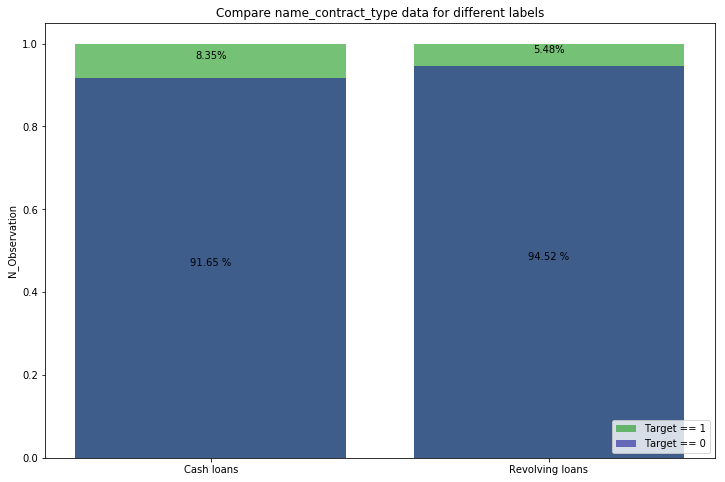

In [26]:
vals = compare_bar_percent(application_train, 'name_contract_type')

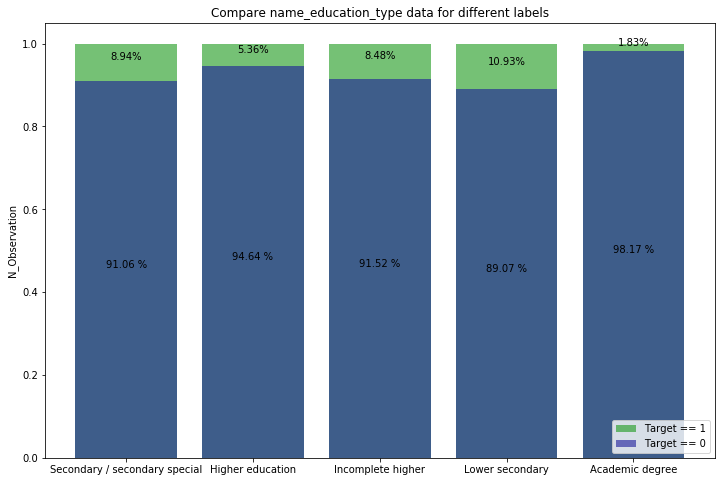

In [27]:
vals = compare_bar_percent(application_train, 'name_education_type')

In [28]:
def plot_dist(data, feature, title = "", color = 'blue'):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of {}".format(feature) + title)
    sns.distplot(data[feature].dropna(), bins=100, color = color)
    plt.show()   

In [29]:
def plot_dist_compare(data, feature):
    plot_dist(data[data.target == 0], feature, 'where target == 0', color = 'green')
    plot_dist(data[data.target == 1], feature, 'where target == 1', color = 'red')

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


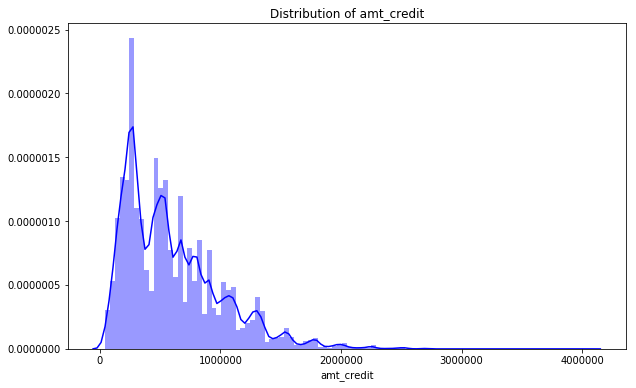

In [30]:
plot_dist(application_train, 'amt_credit')

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


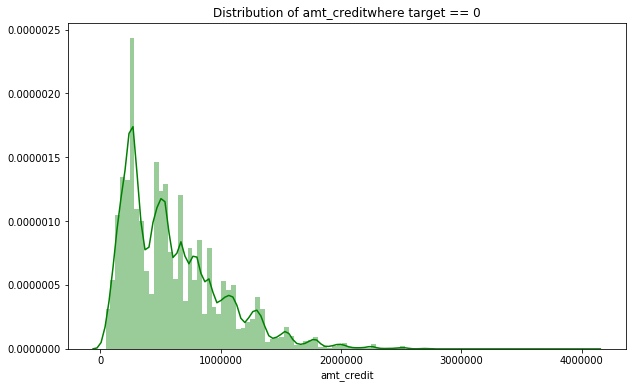

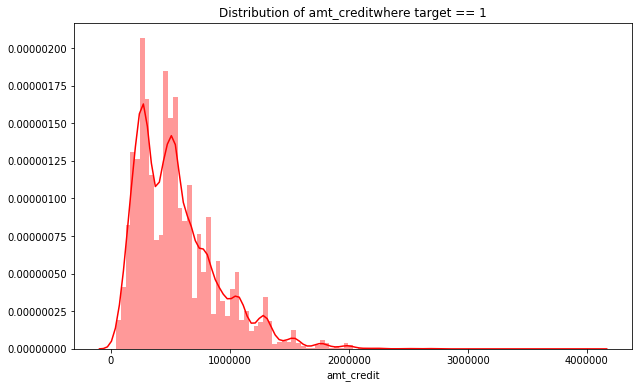

In [31]:
plot_dist_compare(application_train, 'amt_credit')

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


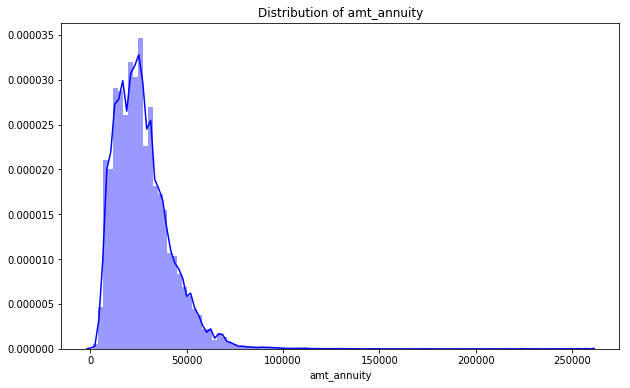

In [32]:
plot_dist(application_train, 'amt_annuity')

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


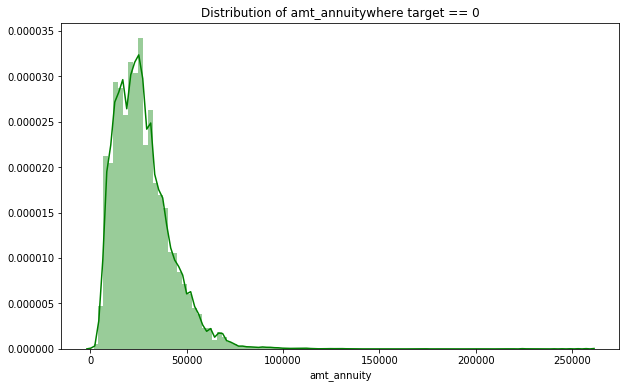

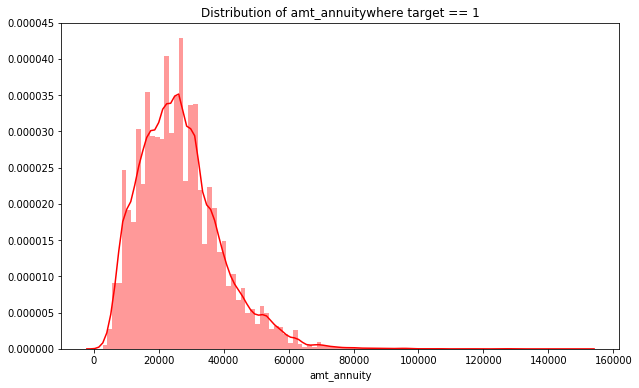

In [33]:
plot_dist_compare(application_train, 'amt_annuity')

# Correlation matrix

In [34]:
def corr_plot(data):
    corr = data.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    f, ax = plt.subplots(figsize=(15, 12))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1., center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    

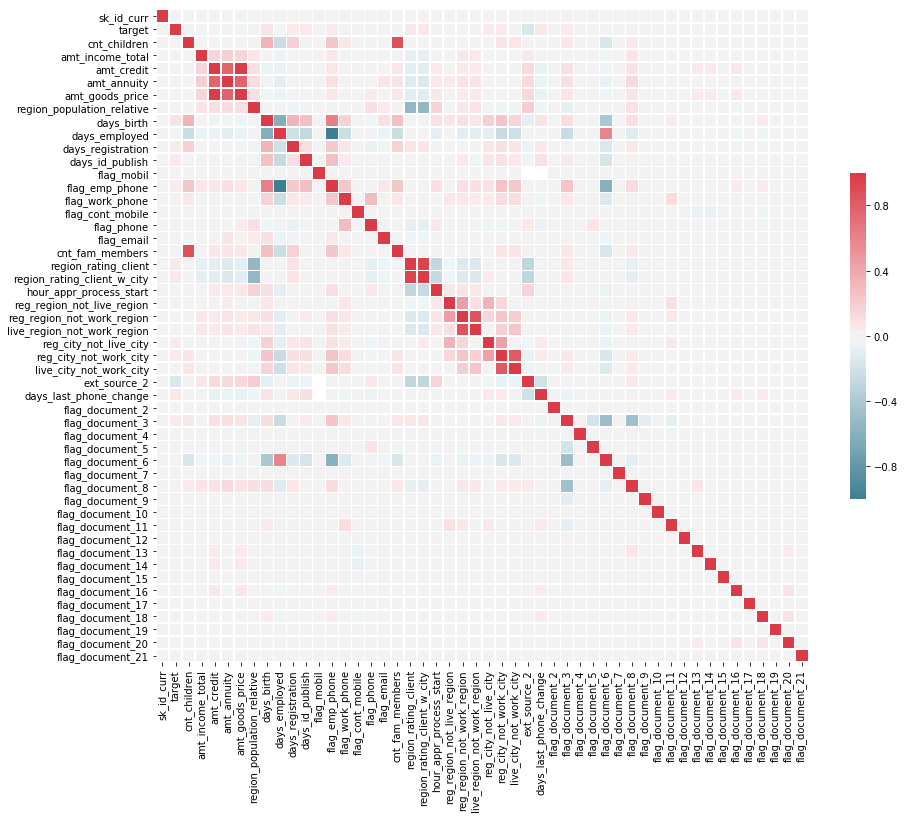

In [35]:
corr_plot(application_train)

# Find important features with Random forest

In [36]:
app_train = application_train

In [37]:
app_train.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,sk_id_bureau,months_balance,status
0,100002.0,1.0,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,None,None,None
1,100003.0,0.0,Cash loans,F,N,N,0.0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None
2,100004.0,0.0,Revolving loans,M,Y,Y,0.0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None
3,100006.0,0.0,Cash loans,F,N,Y,0.0,135000.0,312682.5,29686.5,...,0.0,None,None,None,None,None,None,None,None,None
4,100007.0,0.0,Cash loans,M,N,Y,0.0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None


In [38]:
application_train.name_education_type.head()

0    Secondary / secondary special
1                 Higher education
2    Secondary / secondary special
3    Secondary / secondary special
4    Secondary / secondary special
Name: name_education_type, dtype: object

In [39]:
app_train.name_education_type.head()

0    Secondary / secondary special
1                 Higher education
2    Secondary / secondary special
3    Secondary / secondary special
4    Secondary / secondary special
Name: name_education_type, dtype: object

In [40]:
from sklearn import preprocessing
categorical_features = [f for f in app_train.columns if app_train[f].dtype == 'object']

for col in categorical_features:
    lb = preprocessing.LabelEncoder()
    lb.fit(list(app_train[col].values.astype('str')))
    app_train[col] = lb.transform(list(app_train[col].values.astype('str')))

In [41]:
app_train.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,sk_id_bureau,months_balance,status
0,100002.0,1.0,0,1,0,1,0.0,202500.0,406597.5,24700.5,...,0.0,0,0,0,0,0,1,0,0,0
1,100003.0,0.0,0,0,0,0,0.0,270000.0,1293502.5,35698.5,...,0.0,0,0,0,0,0,0,0,0,0
2,100004.0,0.0,1,1,1,1,0.0,67500.0,135000.0,6750.0,...,0.0,0,0,0,0,0,0,0,0,0
3,100006.0,0.0,0,0,0,1,0.0,135000.0,312682.5,29686.5,...,0.0,5,9,9,24,11,25,0,0,0
4,100007.0,0.0,0,1,0,1,0.0,121500.0,513000.0,21865.5,...,0.0,0,0,0,0,0,0,0,0,0


In [42]:
app_train.fillna(-999, inplace = True)

In [43]:
app_train_sub = app_train[:10000]

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, max_depth=8, min_samples_leaf=4, max_features=0.5, random_state=2018)
rf.fit(app_train_sub.drop(['sk_id_curr', 'target'],axis=1), app_train_sub.target)
features = app_train_sub.drop(['sk_id_curr', 'target'],axis=1).columns.values

In [45]:
importance_score, feature_list = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), reverse = False)))

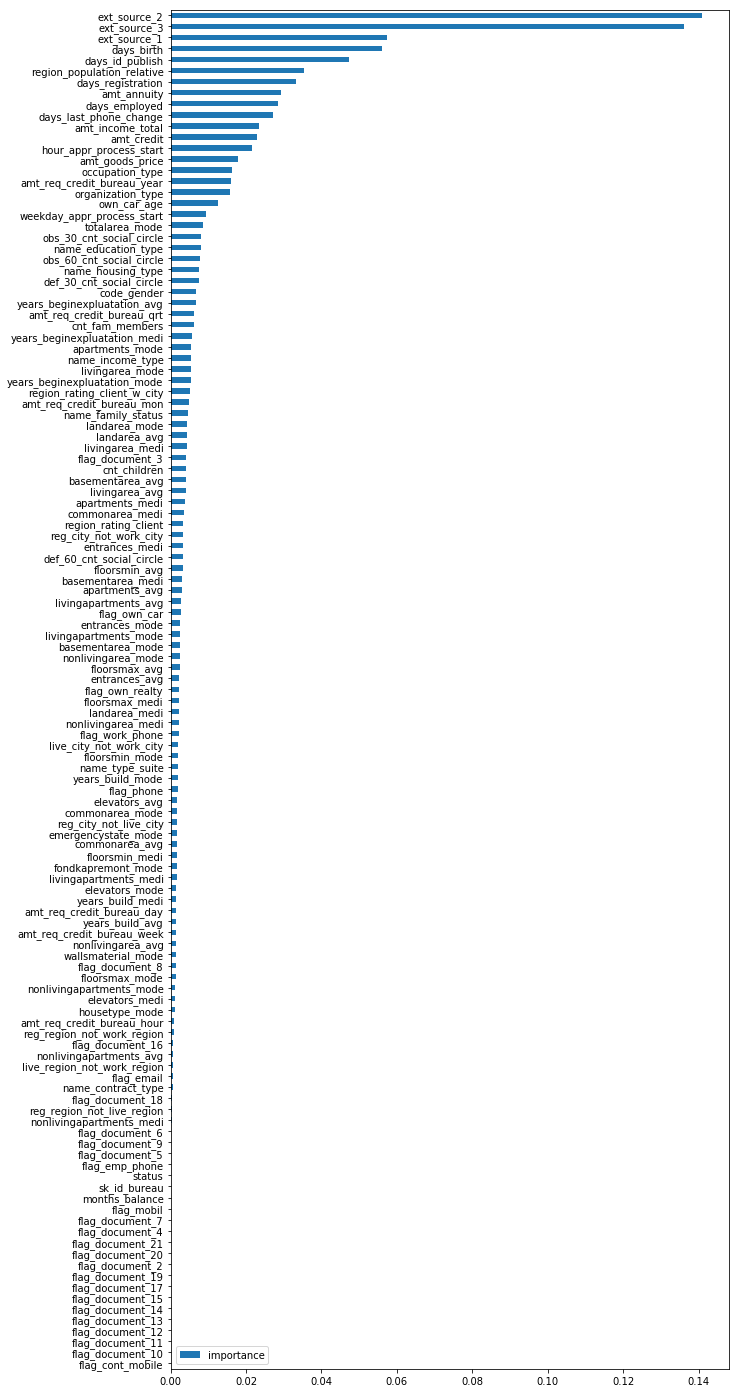

In [46]:
importance = pd.DataFrame({'importance': importance_score}, index=feature_list)
importance.plot.barh(figsize = (10,25))

In [47]:
importance[::-1].index

Index(['ext_source_2', 'ext_source_3', 'ext_source_1', 'days_birth',
       'days_id_publish', 'region_population_relative', 'days_registration',
       'amt_annuity', 'days_employed', 'days_last_phone_change',
       ...
       'flag_document_2', 'flag_document_19', 'flag_document_17',
       'flag_document_15', 'flag_document_14', 'flag_document_13',
       'flag_document_12', 'flag_document_11', 'flag_document_10',
       'flag_cont_mobile'],
      dtype='object', length=123)

# Build training set

* train_1: drop missing values
* train_2: impute missing values

In [48]:
top_5_feature = importance[::-1].index[:5].append(pd.Index(['target']))
top_10_feature = importance[::-1].index[:10].append(pd.Index(['target']))
top_20_feature = importance[::-1].index[:20].append(pd.Index(['target']))

In [49]:
application_train.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,sk_id_bureau,months_balance,status
0,100002.0,1.0,0,1,0,1,0.0,202500.0,406597.5,24700.5,...,0.0,0,0,0,0,0,1,0,0,0
1,100003.0,0.0,0,0,0,0,0.0,270000.0,1293502.5,35698.5,...,0.0,0,0,0,0,0,0,0,0,0
2,100004.0,0.0,1,1,1,1,0.0,67500.0,135000.0,6750.0,...,0.0,0,0,0,0,0,0,0,0,0
3,100006.0,0.0,0,0,0,1,0.0,135000.0,312682.5,29686.5,...,0.0,5,9,9,24,11,25,0,0,0
4,100007.0,0.0,0,1,0,1,0.0,121500.0,513000.0,21865.5,...,0.0,0,0,0,0,0,0,0,0,0


In [50]:
schema = 'kaggle_hcdr'
#table_list = ['application_test', 'application_train', 'bureau', 'bureau_balance', 'credit_card_balance', 'home_credit_columns_description', 'installments_payments', 'pos_cash_balance', 'previous_application', 'sample_submission']
#[application_test, application_train, bureau, bureau_balance, credit_card_balance, home_credit_columns_description, installments_payments, pos_cash_balance, previous_application, sample_submission] = ['']*len(table_list)

table_list = ['application_train']
[application_train_raw] = ['']*len(table_list)

In [141]:
[application_train_raw] = get_data(my_host, my_port, my_db, my_name, my_pwd, schema, table_list)

Processing: application_train


In [173]:
train_1 = application_train_raw[top_5_feature]
train_2 = application_train_raw[top_5_feature]

In [53]:
train_1[top_5_feature].apply(pd.Series.nunique, axis = 0)

ext_source_2       119831
ext_source_3          814
ext_source_1       114584
days_birth          17460
days_id_publish      6168
target                  2
dtype: int64

In [54]:
train_1.dtypes

ext_source_2       float64
ext_source_3        object
ext_source_1        object
days_birth         float64
days_id_publish    float64
target             float64
dtype: object

In [143]:
train_1.head()

,ext_source_2,ext_source_3,ext_source_1,days_birth,days_id_publish,target
0,0.262949,0.13937578009978951,0.08303696739132256,-9461.0,-2120.0,1.0
1,0.622246,None,0.3112673113812225,-16765.0,-291.0,0.0
2,0.555912,0.7295666907060153,None,-19046.0,-2531.0,0.0
3,0.650442,None,None,-19005.0,-2437.0,0.0
4,0.322738,None,None,-19932.0,-3458.0,0.0


In [56]:
top_5_feature

Index(['ext_source_2', 'ext_source_3', 'ext_source_1', 'days_birth',
       'days_id_publish', 'target'],
      dtype='object')

In [57]:
application_train_missing.loc[top_5_feature]

,N_missing,Percent %
ext_source_2,660,0.214626
ext_source_3,60965,19.825307
ext_source_1,173378,56.381073
days_birth,0,0.000000
days_id_publish,0,0.000000
target,0,0.000000


In [174]:
train_1 = train_1.dropna(axis=0, how='any')
train_1 = train_1.reset_index(drop=True)
train_1.head()

,ext_source_2,ext_source_3,ext_source_1,days_birth,days_id_publish,target
0,0.262949,0.13937578009978951,0.08303696739132256,-9461.0,-2120.0,1.0
1,0.724000,0.4920600938649263,0.7747614130547695,-13778.0,-619.0,0.0
2,0.205747,0.7517237147741489,0.5873340468730377,-20099.0,-3514.0,0.0
3,0.651862,0.363945238612397,0.3197601716755032,-10197.0,-738.0,0.0
4,0.555183,0.6528965519806539,0.7220444501416448,-20417.0,-2512.0,0.0


In [175]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(train_2) 

SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)

In [176]:
train_2 = pd.DataFrame(imp.transform(train_2))

In [177]:
train_2.columns = [top_5_feature]
train_2.head()

,ext_source_2,ext_source_3,ext_source_1,days_birth,days_id_publish,target
0,0.262949,0.139376,0.083037,-9461.0,-2120.0,1.0
1,0.622246,0.510853,0.311267,-16765.0,-291.0,0.0
2,0.555912,0.729567,0.502130,-19046.0,-2531.0,0.0
3,0.650442,0.510853,0.502130,-19005.0,-2437.0,0.0
4,0.322738,0.510853,0.502130,-19932.0,-3458.0,0.0


## Data pre-process

In [179]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(train_1.values)
train_1_scaled = pd.DataFrame(x_scaled)
train_1_scaled.columns = [top_5_feature]

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [180]:
x_scaled = min_max_scaler.fit_transform(train_2.values)
train_2_scaled = pd.DataFrame(x_scaled)
train_2_scaled.columns = [top_5_feature]

In [181]:
train_1_scaled.head()

,ext_source_2,ext_source_3,ext_source_1,days_birth,days_id_publish,target
0,0.307541,0.156513,0.072215,0.898351,0.676385,1.0
1,0.846784,0.554066,0.801786,0.651961,0.905511,0.0
2,0.240639,0.846765,0.604104,0.291193,0.463593,0.0
3,0.762412,0.409653,0.321890,0.856344,0.887345,0.0
4,0.649337,0.735365,0.746185,0.273044,0.616547,0.0


In [182]:
train_2_scaled.head()

,ext_source_2,ext_source_3,ext_source_1,days_birth,days_id_publish,target
0,0.307542,0.155054,0.072215,0.888839,0.705433,1.0
1,0.727773,0.569889,0.312933,0.477114,0.959566,0.0
2,0.650190,0.814130,0.514238,0.348534,0.648326,0.0
3,0.760751,0.569889,0.514238,0.350846,0.661387,0.0
4,0.377472,0.569889,0.514238,0.298591,0.519522,0.0


# Train model and CV - Logistic reg, KNN, DT

In [223]:
def logistic_reg(train_x, train_y, test_x, test_y, solver = 'lbfgs'):
    clf = LogisticRegression(random_state = 0, solver = solver).fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    #prob_y = clf.predict_proba(test_x) 
    #clf.score(train, y)
    accu = np.sum(predict_y == test_y) / len(test_y)
    return predict_y, accu
    

In [225]:
def knn_model(train_x, train_y, test_x, test_y, n_neighbors = 5, algorithm = 'auto'):
    neigh = KNeighborsClassifier(n_neighbors = n_neighbors, algorithm = algorithm).fit(train_x, train_y) 

    predict_y = neigh.predict(test_x)
    #prob_y = neigh.predict_proba(test_x)
    accu = np.sum(predict_y == test_y) / len(test_y)
    return predict_y, accu

In [ ]:
import graphviz 
>>> dot_data = tree.export_graphviz(clf, out_file=None) 
>>> graph = graphviz.Source(dot_data) 
>>> graph.render("iris") 

In [ ]:
tree.export_graphviz(clf,
...     out_file='tree.dot') 

In [247]:
def decision_tree_model(train_x, train_y, test_x, test_y):
    clf = sk.tree.DecisionTreeClassifier()
    clf = clf.fit(train_x, train_y)
    
    predict_y = clf.predict(test_x)
    #prob_y = clf.predict_proba(test_x) 
    accu = np.sum(predict_y == test_y) / len(test_y)
    
    return predict_y, accu, clf
    

In [244]:
def train_model(data_set):

    kf = KFold(n_splits=5)

    accu_logis_l = []
    accu_knn_l = []
    accu_dt_l = []
    
    for train, test in kf.split(data_set):
        train_set = data_set.loc[train]
        test_set = data_set.loc[test]
        
        train_x = train_set.loc[:, train_set.columns != 'target']
        train_y = train_set['target']
        test_x = test_set.loc[:, test_set.columns != 'target']
        test_y = test_set['target']
        
        # logistic regression
        _, accu_logis= logistic_reg(train_x, train_y, test_x, test_y, solver = 'lbfgs')
        accu_logis_l.append(accu_logis)
        
        # KNN
        _, accu_knn= knn_model(train_x, train_y, test_x, test_y, n_neighbors = 5, algorithm = 'auto')
        accu_knn_l.append(accu_knn)
        
        # DT
        _, accu_dt= decision_tree_model(train_x, train_y, test_x, test_y)
        accu_dt_l.append(accu_dt)
        
    
    accu_logis_mean = np.mean(accu_logis_l)
    accu_knn_mean = np.mean(accu_knn_l)
    accu_dt_mean = np.mean(accu_dt_l)
        
    return accu_logis_mean, accu_knn_mean, accu_dt_mean

In [245]:
train_model(train_1)

(0.9270182303514461, 0.9235963573978216, 0.8682714518902064)

In [246]:
train_model(train_2)

(0.9192711785833719, 0.9145526483371856, 0.8549450239078533)

### Example of decision tree

In [256]:
_ , _ , c = decision_tree_model(train_x, train_y, test_x, test_y)

In [251]:
sk.tree.export_graphviz(a,out_file='tree.dot') 

In [ ]:
#from IPython.display import SVG

In [ ]:
dot_data = sk.tree.export_graphviz(c, out_file=None, 
                                feature_names=top_5_feature[:5],  
                                class_names=top_5_feature[5])

graph = pydotplus.graph_from_dot_data(dot_data) 